In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
%matplotlib inline

import json
from glob import glob

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A

data_root = '../input/'
train_image_root = data_root + 'train_images/'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import pandas as pd
import numpy as np
import pytorch_lightning as pl

from config import cfg
from dataset import CassavaLeafDataModule
from train import CassavaLeafModel
from sklearn.model_selection import StratifiedKFold

In [5]:
def get_img(path):
    return cv2.imread(path)[:, :, ::-1]

def show_img(imgs, labels=None, transform=None):
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    for i, ax in enumerate(axes.flatten()):
        ax.set_axis_off()
        img = imgs[i]
        if transform:
            img = transform(image=img)['image']
        ax.imshow(img)
        if labels is not None:
            ax.set_title(labels[i])

In [6]:
df = pd.read_csv(data_root + 'train.csv')
samples = df.groupby('label').apply(lambda d: d.sample(n=4))
samples.image_id = train_image_root + samples.image_id
imgs = [get_img(image_id) for image_id in samples.image_id.values]

# show_img(imgs, samples.label.values)

In [34]:
transform = A.Compose([
    A.ShiftScaleRotate(p=0.6),
    # A.CenterCrop(cfg.data.img_size, cfg.data.img_size, p=0.5), # all focus on local, ok?
    # fcrs
    A.OneOf([
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
    ], p=0.5),
    # # blur
    # A.OneOf([
    #     A.MotionBlur(blur_limit=(7,21), p=0.2),
    #     A.GaussianBlur(blur_limit=(7,21), p=0.8),
    # ], p=0.5),
    # # noise
    # A.OneOf([
    #     A.GaussNoise(p=1.0),
    #     A.ISONoise(p=1.0),
    # ], p=0.5),
    # color
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=60, val_shift_limit=40, p=1.0),
        A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.1, 0.1), p=1.0),
    ], p=1.0),
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
    A.Cutout(16, max_h_size=16, max_w_size=16, p=1.0),
    A.Resize(456, 456),
])

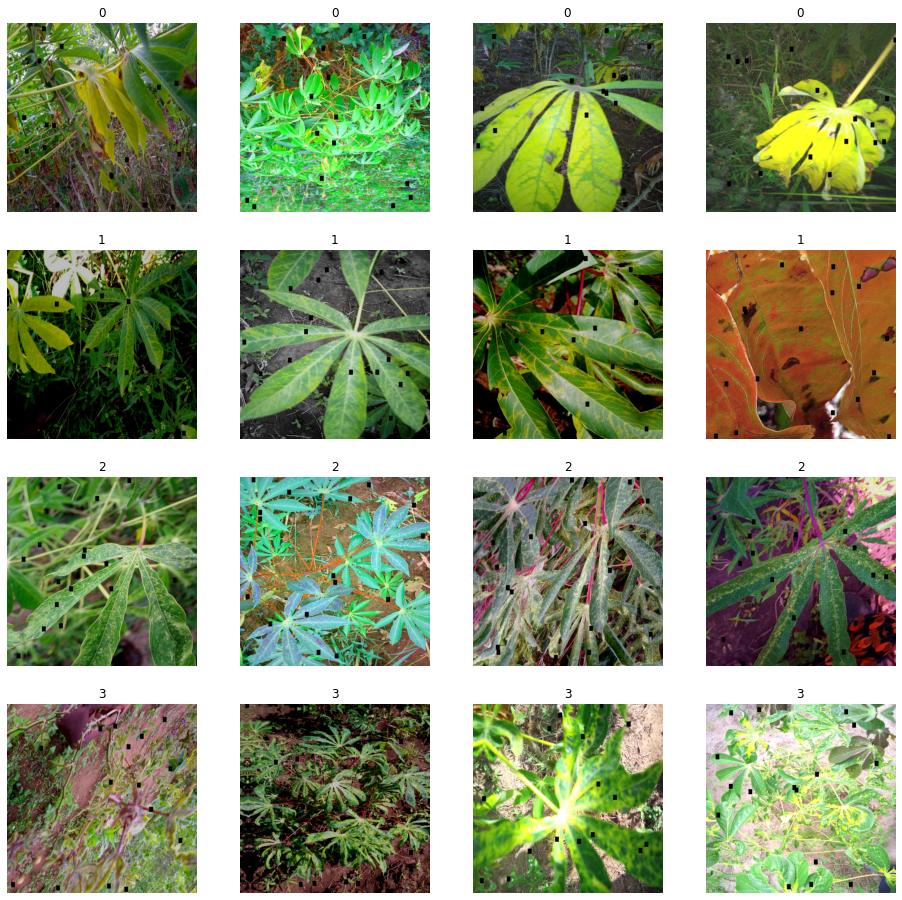

In [35]:
show_img(imgs, samples.label.values, transform)

# Test TrainLoader

In [23]:
df_train = pd.read_csv('../input/train.csv')
folds = StratifiedKFold(
    n_splits=cfg.data.num_folds, 
    shuffle=True, 
    random_state=cfg.seed).split(
        np.arange(df_train.shape[0]), df_train.label.values)
        
for fold, (trn_idx, val_idx) in enumerate(folds):
    dm = CassavaLeafDataModule(df_train, trn_idx, val_idx)
    dm.setup()
    break

In [24]:
dataset = dm.train_dataset
datas = [(dataset[i][0]).permute(1, 2, 0) for i in range(16, 32)]

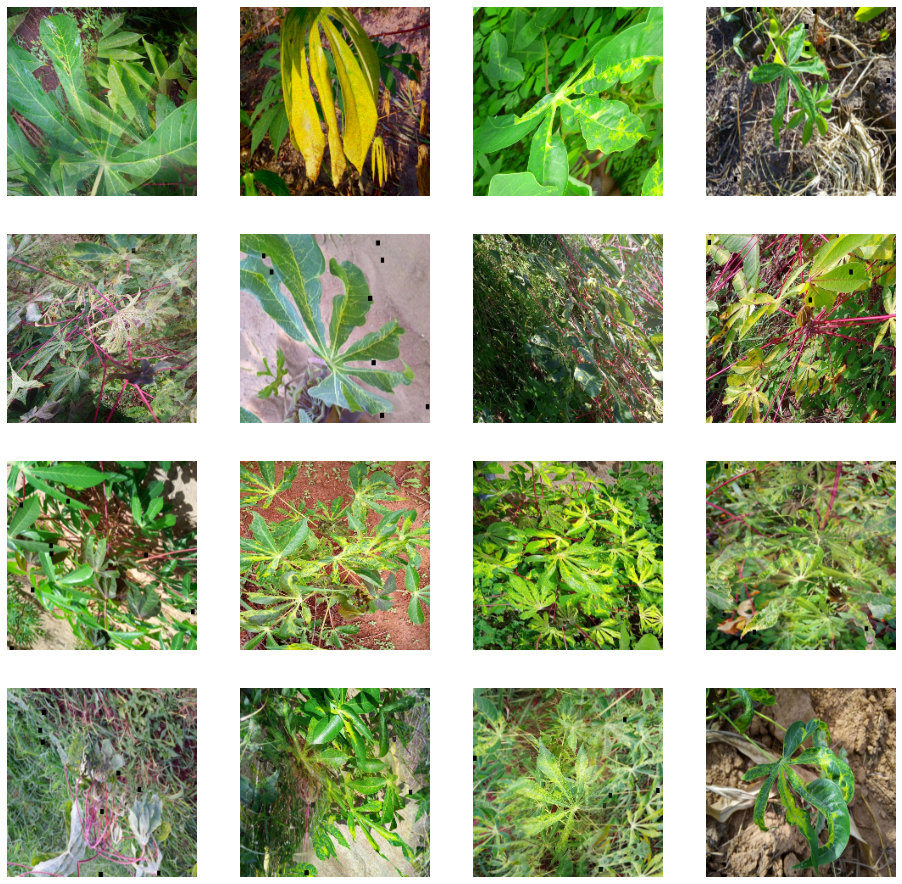

In [25]:
show_img(datas)